# 有限元算例不可压缩Navier-Stokles方程IPCS方法求解
本节将引导您使用 FEALPy.CFD 完成非稳态不可压缩流体的 Navier-Stokes 方程的 IPCS 方法的有限元求解，现定义如下数学模型：
$$\begin{cases}\rho\left[\frac{\partial \bm{u}}{\partial t}+(\bm{u} \cdot \nabla)\bm{u} \right] = \nabla\cdot\bm{\sigma}(\bm{u}, p) + \bm{f}  &\text{in }\Omega \times (0,T]\\\nabla \cdot \bm{u} = \bm{0}  &\text{in } \Omega \times (0,T]\\\bm{u} = \bm{g}_u &\text{on } \partial \Omega \times (0,T]\\\bm{u}(\cdot ,0) = \bm{u}_0 &\text{in }\Omega\end{cases}$$
$$\int_{\Omega} p \, dx = 0,$$
其中：
- $\boldsymbol{u}$ 表示速度场，
- $p$ 表示压力，
- $\boldsymbol f$为外力，
- $\Omega$为计算区域。
- $\mu$ 分子粘性系数
- $\rho$代表流体密度

Cauchy 应力张量 $\bm{\sigma}$可以分解为压力项（体积应力，volumetric stress）$-p\bm{I}$和粘性项 $\bm{\tau}$（偏应力，deviatoricstress）的和的形式
$$\bm{\sigma}= \bm{\tau} - p\bm{I},$$
其中 $\bm{\tau}$和应变率 $\bm{d}$、速度 $\bm{u}$的关系为：
$$\bm{\tau}= 2 \mu \bm{\varepsilon},\bm{\varepsilon} = \frac{1}{2} (\bm{u}\otimes \nabla + \nabla\otimes \bm{u}).$$

我们定义真解为
$$\boldsymbol u = (u_1, u_2) $$
$$u_1(x, y) = 0.05e^{-t}x^2(x-1)^2(4y^3-6y^2+2y), u_2(x, y) = -0.05e^{-t}(4x^3-6x^2+2x)y^2(y-1)^2$$
$$p(x, y) = 0.05e^{-t}(x^2+y^2-\frac{2}{3})$$

## 1.定义PDE类型

In [15]:
from typing import Sequence
from fealpy.decorator import cartesian
from fealpy.backend import backend_manager as bm
from fealpy.backend import TensorLike
from fealpy.mesher import BoxMesher2d

class Exp0002(BoxMesher2d):
    def __init__(self, options: dict = {}):
        self.options = options
        self.box = [0.0, 1.0, 0.0, 1.0]
        self.eps = 1e-10
        self.mu = 1.0
        self.rho = 1.0
        self.mesh = self.init_mesh(nx=options.get('nx', 8), ny=options.get('ny', 8))
        super().__init__(box=self.box)
        
    @cartesian
    def velocity(self, p: TensorLike, t) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = 0.05 * bm.exp(-t) * x **2 * (x-1)**2 * (4 * y**3 - 6 * y**2 + 2*y)
        result[..., 1] = -0.05 * bm.exp(-t) * (4 * x**3 - 6 * x**2 + 2 * x) * y**2 * (y - 1)**2
        return result
    
    @cartesian
    def velocity_0(self, p):
        return self.velocity(p, self.t0)

    @cartesian
    def pressure_0(self, p: TensorLike) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        return self.pressure(p, self.t0)
    
    @cartesian
    def pressure(self, p, t):
        x = p[..., 0]
        y = p[..., 1]
        return 0.05 * bm.exp(-t) * (x**2 + y**2 - 2/3)
    
    @cartesian
    def source(self, p: TensorLike, t) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = -0.0025*x**2*y**2*(x - 1)**2*(y - 1)**2*(4*x**3 - 6*x**2 + 2*x)*(12*y**2 - 12*y + 2)*bm.exp(-2*t) - 0.05*x**2*(x - 1)**2*(24*y - 12)*bm.exp(-t) + 0.05*x**2*(x - 1)**2*(0.05*x**2*(2*x - 2)*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t) + 0.1*x*(x - 1)**2*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t))*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t) - 0.05*x**2*(x - 1)**2*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t) - 0.1*x**2*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t) - 0.2*x*(2*x - 2)*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t) + 0.1*x*bm.exp(-t) - 0.1*(x - 1)**2*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-t)
        result[..., 1] = -0.0025*x**2*y**2*(x - 1)**2*(y - 1)**2*(12*x**2 - 12*x + 2)*(4*y**3 - 6*y**2 + 2*y)*bm.exp(-2*t) + 0.05*y**2*(24*x - 12)*(y - 1)**2*bm.exp(-t) - 0.05*y**2*(y - 1)**2*(-0.05*y**2*(2*y - 2)*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t) - 0.1*y*(y - 1)**2*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t))*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t) + 0.05*y**2*(y - 1)**2*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t) + 0.1*y**2*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t) + 0.2*y*(2*y - 2)*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t) + 0.1*y*bm.exp(-t) + 0.1*(y - 1)**2*(4*x**3 - 6*x**2 + 2*x)*bm.exp(-t)
        return result

    @cartesian
    def is_velocity_boundary(self, p: TensorLike) -> TensorLike:
        return None

    @cartesian
    def is_pressure_boundary(self, p: TensorLike = None) -> TensorLike:
        return 0

    @cartesian
    def velocity_dirichlet(self, p: TensorLike, t) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        return result
    
    @cartesian
    def pressure_dirichlet(self, p: TensorLike, t) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        return None


## 2. 进行参数配置和初始化

In [16]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [17]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

定义求解参数

In [18]:
tol = 1e-10
maxstep = 10
maxit = 4

定义误差存储矩阵

In [19]:
u_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)
p_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

## 3.有限元求解

流程包含：

- 构建求解方程的equation以及求解方法fem

- 设置速度和压力的空间

- 组装刚度矩阵 $A$ 和载荷向量 $F$

- 处理Dirichlet边界条件

- 求解线性系统 $A u_h = F$

- 计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

- 网格均匀加密

In [20]:
from fealpy.cfd.equation.incompressible_ns import IncompressibleNS
from fealpy.cfd.simulation.fem.incompressible_ns import IPCS
from fealpy.solver import spsolve
from fealpy.cfd.simulation.time import UniformTimeLine
from fealpy.fem import DirichletBC

tol = 1e-10
maxstep = 10
pde = Exp0002()
equation = IncompressibleNS(pde)
mesh = pde.init_mesh['uniform_tri'](nx=2, ny=2)
fem = IPCS(equation, mesh)
fem.set.uspace('Lagrange', p=2)
fem.set.pspace('Lagrange', p=1)
nt = 50

for i in range(maxit):
    timeline = UniformTimeLine(T0=0, T1=1, NT=nt)
    fem.dt = timeline.dt
    u0 = fem.uspace.interpolate(cartesian(lambda p: pde.velocity(p, t = timeline.T0)))
    p0 = fem.pspace.interpolate(cartesian(lambda p: pde.pressure(p, t = timeline.T0)))
    
    u0 = fem.uspace.function()
    p0 = fem.pspace.function()
    for j in range(timeline.NL-1):
        t  = timeline.current_time()
        print("time=", t)
        
        BCu = DirichletBC(space=fem.uspace, 
                gd = cartesian(lambda p : pde.velocity_dirichlet(p, timeline.next_time())), 
                threshold=pde.is_velocity_boundary, 
                method='interp')

        BCp = DirichletBC(space=fem.pspace,
            gd = cartesian(lambda p : pde.pressure_dirichlet(p, timeline.next_time())), 
            threshold=pde.is_pressure_boundary, 
            method='interp')
        
        uh1 = u0.space.function()
        uhs = u0.space.function()
        ph1 = p0.space.function()
        
        
        equation.set_coefficient('body_force', cartesian(lambda p: pde.source(p, timeline.next_time())))  
        
        A0, b0 = fem.predict_velocity(u0, p0, BC=BCu, return_form=False)
        uhs[:] = spsolve(A0, b0, 'mumps')

        A1, b1 = fem.pressure(uhs, p0, BC=BCp, return_form=False)
        if equation.pressure_neumann == True:
            ph1[:] = spsolve(A1, b1, 'mumps')[:-1]
        else:
            ph1[:] = spsolve(A1, b1, 'mumps')

        A2, b2 = fem.correct_velocity(uhs, p0, ph1, return_form=False)
        uh1[:] = spsolve(A2, b2, 'mumps')

        u0[:] = uh1
        p0[:] = ph1

        uerror = mesh.error(cartesian(lambda p : pde.velocity(p, t = t)), uh1)
        perror = mesh.error(cartesian(lambda p : pde.pressure(p, t = t)), ph1)
        print(f"uerror: {uerror},  perror: {perror}")
        timeline.advance()
    u_errorMatrix[0, i] = uerror
    p_errorMatrix[0, i] = perror
    if i < maxit - 1:
        mesh.uniform_refine()
        fem.update_mesh(mesh)
        nt = nt * 4


time= 0.0
uerror: 0.0004424265744637115,  perror: 0.012255201628909513
time= 0.02
uerror: 0.00033016080619295335,  perror: 0.0059188368070299075
time= 0.04
uerror: 0.0002053531166429832,  perror: 0.003110230720054951
time= 0.06
uerror: 0.0001422097438433598,  perror: 0.002255244298086861
time= 0.08
uerror: 0.00012366243653985062,  perror: 0.001957355528903121
time= 0.1
uerror: 0.000118694572137596,  perror: 0.0017772239996130537
time= 0.12
uerror: 0.00011575501502613294,  perror: 0.001653066962170283
time= 0.14
uerror: 0.00011306074111126493,  perror: 0.0015664652180922421
time= 0.16
uerror: 0.00011055289360207097,  perror: 0.001502276888735667
time= 0.18
uerror: 0.00010822862120181509,  perror: 0.001450560918061654
time= 0.2
uerror: 0.00010604065569885477,  perror: 0.00140583470767134
time= 0.22
uerror: 0.00010394265901542436,  perror: 0.0013652276612760002
time= 0.24
uerror: 0.00010190434339179612,  perror: 0.0013272465323155987
time= 0.26
uerror: 9.990955083552786e-05,  perror: 0.00

KeyboardInterrupt: 

## 4.误差分析和收敛阶计算

In [ ]:
next(tmr)
print("速度最终误差",u_errorMatrix)
print("order : ", bm.log2(u_errorMatrix[0,:-1]/u_errorMatrix[0,1:]))
print("压力最终误差",p_errorMatrix)  
print("order : ", bm.log2(p_errorMatrix[0,:-1]/p_errorMatrix[0,1:]))


Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
速度最终误差 [[4.86640117e-05 7.49448881e-06 8.58656250e-07 1.06904893e-07]]
order :  [2.69895327 3.12567749 3.0057528 ]
压力最终误差 [[5.76606257e-04 1.44740340e-04 3.25519309e-05 7.97323114e-06]]
order :  [1.99411943 2.15265203 2.02950672]


## 5.结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

/home/libz/pytorch_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/libz/pytorch_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/libz/pytorch_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/libz/pytorch_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


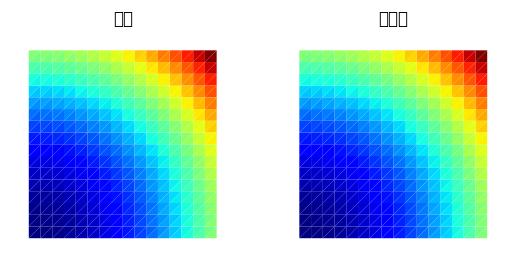

In [ ]:
from matplotlib import pyplot as plt

bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
ps = mesh.bc_to_point(bc)
p = pde.pressure(ps, t)
ph = ph1(bc)

fig, axes = plt.subplots(1, 2)
mesh.add_plot(axes[0], cellcolor=p, linewidths=0)
axes[0].set_title('真解')
mesh.add_plot(axes[1], cellcolor=ph, linewidths=0)
axes[1].set_title('数值解')
plt.show()
